In [14]:
import os
import random
import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import defaultdict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skimage import exposure
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.io import imread
from skimage.transform import resize, rotate
from tqdm import tqdm

# **Load Data**

In [4]:
os.listdir('/kaggle/input/mammals-image-classification-dataset-45-animals/mammals')

['wildebeest',
 'warthog',
 'horse',
 'red_panda',
 'mongoose',
 'otter',
 'sea_lion',
 'jackal',
 'koala',
 'orangutan',
 'manatee',
 'porcupine',
 'kangaroo',
 'blue_whale',
 'mountain_goat',
 'highland_cattle',
 'vicuna',
 'yak',
 'polar_bear',
 'zebra',
 'seal',
 'brown_bear',
 'wombat',
 'tapir',
 'armadillo',
 'alpaca',
 'water_buffalo',
 'snow_leopard',
 'anteater',
 'badger',
 'giraffe',
 'arctic_fox',
 'rhinoceros',
 'dolphin',
 'camel',
 'vampire_bat',
 'baboon',
 'sugar_glider',
 'squirrel',
 'weasel',
 'walrus',
 'american_bison',
 'groundhog',
 'opossum',
 'african_elephant']

In [5]:
dataset_path = '/kaggle/input/mammals-image-classification-dataset-45-animals/mammals'
selected_classes = ['polar_bear', 'red_panda', 'squirrel']  # ['polar_bear', 'red_panda', 'squirrel'], ['groundhog', 'baboon', 'armadillo']
max_images_per_class = 300

In [6]:
images = []
labels = []
image_count = defaultdict(int)

for label in selected_classes:
    class_path = os.path.join(dataset_path, label)
    image_files = os.listdir(class_path)
    loaded = 0

    for file in image_files:
        if image_count[label] >= max_images_per_class:
            break

        img_path = os.path.join(class_path, file)
        try:
            img = imread(img_path)
            images.append(img)
            labels.append(label)
            image_count[label] += 1
            loaded += 1
        except Exception as e:
            print(f"Gagal membaca data citra {img_path}: {e}")

print(f"Dataset berhasil dimuat. \nTotal citra: {len(images)} dari {len(selected_classes)} kelas.")

Dataset berhasil dimuat. 
Total citra: 900 dari 3 kelas.


# **Preprocessing Data**

In [7]:
def zoom_center_crop(image, zoom_factor=0.8):
    h, w = image.shape
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    cropped = image[top:top + new_h, left:left + new_w]
    return resize(cropped, (h, w), anti_aliasing=True)

def preprocess_image(image, size=(128, 128)):
    image_resized = resize(image, size, anti_aliasing=True)
    gray = rgb2gray(image_resized)
    return gray

def augment_image(gray_image):
    flipped = np.fliplr(gray_image)
    rotated = rotate(gray_image, angle=90, resize=False)
    zoomed = zoom_center_crop(gray_image, zoom_factor=0.8)

    return [gray, flipped, rotated, zoomed]

In [8]:
preprocessed_images = []
augmented_labels = []

for img, label in zip(images, labels):
    gray = preprocess_image(img)
    augmented = augment_image(gray)

    preprocessed_images.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

print(f"Preprocessing & Augmentasi selesai. \nTotal citra yang diproses: {len(preprocessed_images)} dari {len(selected_classes)} kelas.")

Preprocessing & Augmentasi selesai. 
Total citra yang diproses: 3600 dari 3 kelas.


# **Feature Extraction**

In [9]:
# Ekstraksi Fitur HOG
def extract_hog_features(image):
    hog_image, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True,
                      feature_vector=True)
    return hog_image
    
X_hog = [extract_hog_features(img) for img in preprocessed_images]
print(f"Ekstraksi fitur HOG selesai. \nTotal: {len(X_hog)} dari {len(selected_classes)} kelas.")

Ekstraksi fitur HOG selesai. 
Total: 3600 dari 3 kelas.


In [10]:
# Ekstraksi Fitur LBP
def extract_lbp_features(image, P=8, R=1):
    image_uint8 = img_as_ubyte(image) 
    lbp = local_binary_pattern(image_uint8, P, R, method='uniform')
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist
    
X_lbp = [extract_lbp_features(img) for img in preprocessed_images]
print(f"Ekstraksi fitur LBP selesai. \nTotal: {len(X_lbp)} dari {len(selected_classes)} kelas.")

Ekstraksi fitur LBP selesai. 
Total: 3600 dari 3 kelas.


In [11]:
# Ekstraksi Fitur Gabor Filter
def extract_gabor_features(image, frequencies=[0.6], thetas=[0, np.pi/4, np.pi/2]):
    features = []
    for theta in thetas:
        for frequency in frequencies:
            kernel = cv2.getGaborKernel(ksize=(21, 21), sigma=4.0,
                                        theta=theta, lambd=1.0/frequency,
                                        gamma=0.5, psi=0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            features.append(filtered.mean())
            features.append(filtered.var())
    return features
    
X_gabor = [extract_gabor_features(img) for img in preprocessed_images]
print(f"Ekstraksi fitur Gabor selesai. \nTotal: {len(X_gabor)} dari {len(selected_classes)} kelas.")

Ekstraksi fitur Gabor selesai. 
Total: 3600 dari 3 kelas.


In [12]:
# Ekstraksi Fitur GLCM
def extract_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image_uint8 = img_as_ubyte(image)
    glcm = graycomatrix(image_uint8,
                        distances=distances,
                        angles=angles,
                        symmetric=True,
                        normed=True)

    features = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    for prop in properties:
        vals = graycoprops(glcm, prop)
        features.extend(vals.flatten())

    return features

X_glcm = [extract_glcm_features(img) for img in preprocessed_images]
print(f"Ekstraksi fitur GLCM selesai. \nTotal: {len(X_glcm)} dari {len(selected_classes)} kelas.")

Ekstraksi fitur GLCM selesai. 
Total: 3600 dari 3 kelas.


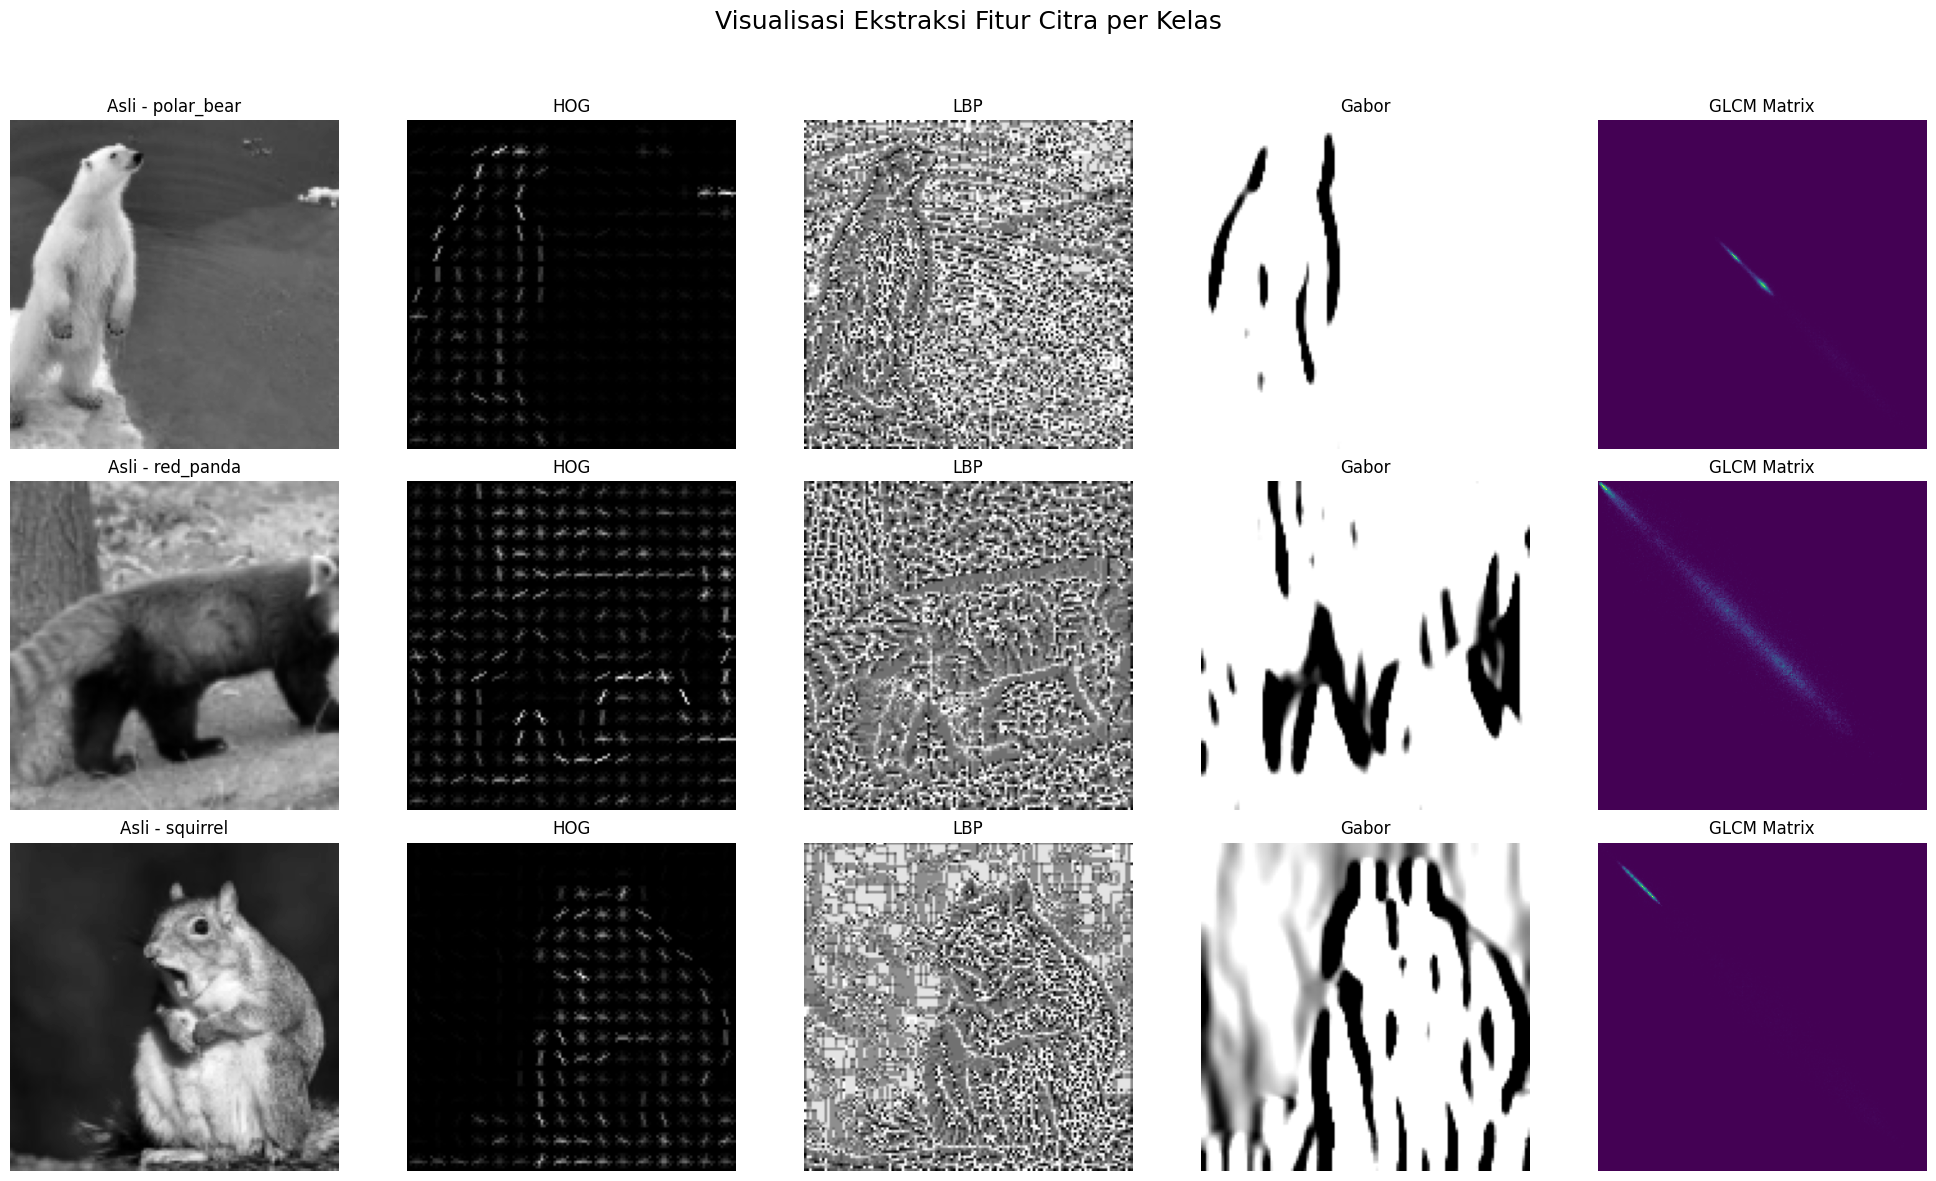

In [21]:
# Ambil 1 gambar acak dari setiap kelas
sample_images = {}
for label in selected_classes:
    idxs = [i for i, l in enumerate(augmented_labels) if l == label]
    if idxs:
        sample_idx = random.choice(idxs)
        sample_images[label] = preprocessed_images[sample_idx]

# Visualisasi hasil ekstraksi fitur sebagai citra
fig, axes = plt.subplots(len(selected_classes), 5, figsize=(20, 12))
fig.suptitle("Visualisasi Ekstraksi Fitur Citra per Kelas", fontsize=18)

for row_idx, (label, image) in enumerate(sample_images.items()):
    # Asli (grayscale)
    axes[row_idx][0].imshow(image, cmap='gray')
    axes[row_idx][0].set_title(f"Asli - {label}")
    axes[row_idx][0].axis('off')

    # HOG visualisasi (gunakan image=True)
    _, hog_image = hog(image,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axes[row_idx][1].imshow(hog_image_rescaled, cmap='gray')
    axes[row_idx][1].set_title("HOG")
    axes[row_idx][1].axis('off')

    # LBP visualisasi
    lbp_image = local_binary_pattern(img_as_ubyte(image), P=8, R=1, method='uniform')
    axes[row_idx][2].imshow(lbp_image, cmap='gray')
    axes[row_idx][2].set_title("LBP")
    axes[row_idx][2].axis('off')

    # Gabor visualisasi (gunakan salah satu kernel, misal theta=0)
    kernel = cv2.getGaborKernel((21, 21), sigma=4.0, theta=0,
                                lambd=10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F)
    gabor_response = cv2.filter2D(img_as_ubyte(image), cv2.CV_8UC3, kernel)
    axes[row_idx][3].imshow(gabor_response, cmap='gray')
    axes[row_idx][3].set_title("Gabor")
    axes[row_idx][3].axis('off')

    # GLCM visualisasi (gunakan matrix co-occurrence)
    image_uint8 = img_as_ubyte(image)
    glcm = graycomatrix(image_uint8, distances=[1], angles=[0], symmetric=True, normed=True)
    glcm_vis = glcm[:, :, 0, 0]  # ambil channel 0 dari jarak 1 & sudut 0
    axes[row_idx][4].imshow(glcm_vis, cmap='viridis')
    axes[row_idx][4].set_title("GLCM Matrix")
    axes[row_idx][4].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# **Training Model**

In [39]:
# LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(augmented_labels)

In [40]:
# Grafik Convolution Matrix
def plot_confusion_matrix(y_true, y_pred, method_name="Metode"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {method_name}")
    plt.tight_layout()
    plt.show()

In [41]:
# Training Model SVM
def train_and_evaluate_svm(X_features, y_labels, method_name="Metode"):
    print(f"\nTraining SVM untuk metode: {method_name}")

    # Normalisasi
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

    # SVM model
    model = SVC(kernel='linear', C=1)

    # Simulasi training progress bar
    for _ in tqdm(range(1), desc=f"Training SVM ({method_name})"):
        model.fit(X_train, y_train)

    # Evaluasi
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nEvaluasi SVM untuk metode: {method_name}")
    print(f"Akurasi: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    
    # Tampilkan confusion matrix
    plot_confusion_matrix(y_test, y_pred, method_name)

    return model  # jika ingin disimpan atau dipakai lagi


Training SVM untuk metode: HOG


Training SVM (HOG): 100%|██████████| 1/1 [00:59<00:00, 59.61s/it]



Evaluasi SVM untuk metode: HOG
Akurasi: 0.6069
Classification Report:
              precision    recall  f1-score   support

  polar_bear       0.64      0.69      0.67       240
   red_panda       0.59      0.58      0.59       240
    squirrel       0.58      0.55      0.56       240

    accuracy                           0.61       720
   macro avg       0.61      0.61      0.61       720
weighted avg       0.61      0.61      0.61       720



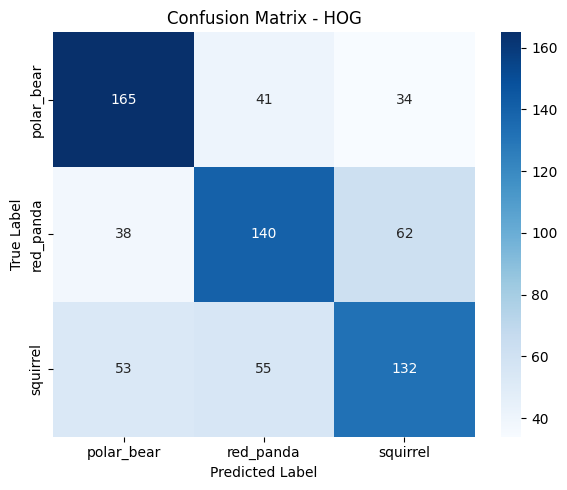

In [42]:
model_hog = train_and_evaluate_svm(X_hog, y_encoded, method_name="HOG")


Training SVM untuk metode: LBP


Training SVM (LBP): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]



Evaluasi SVM untuk metode: LBP
Akurasi: 0.6292
Classification Report:
              precision    recall  f1-score   support

  polar_bear       0.80      0.75      0.77       240
   red_panda       0.55      0.61      0.58       240
    squirrel       0.56      0.53      0.54       240

    accuracy                           0.63       720
   macro avg       0.63      0.63      0.63       720
weighted avg       0.63      0.63      0.63       720



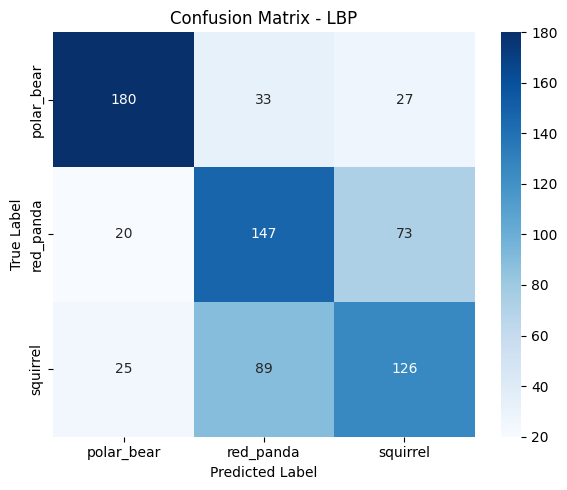

In [44]:
model_lbp = train_and_evaluate_svm(X_lbp, y_encoded, method_name="LBP")


Training SVM untuk metode: Gabor Filter


Training SVM (Gabor Filter): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Evaluasi SVM untuk metode: Gabor Filter
Akurasi: 0.4708
Classification Report:
              precision    recall  f1-score   support

  polar_bear       0.54      0.49      0.51       240
   red_panda       0.42      0.71      0.53       240
    squirrel       0.55      0.21      0.31       240

    accuracy                           0.47       720
   macro avg       0.50      0.47      0.45       720
weighted avg       0.50      0.47      0.45       720



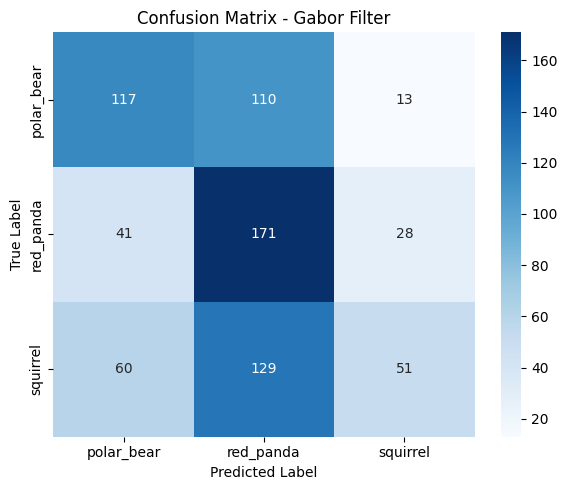

In [43]:
model_gabor = train_and_evaluate_svm(X_gabor, y_encoded, method_name="Gabor Filter")


Training SVM untuk metode: GLCM


Training SVM (GLCM): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]



Evaluasi SVM untuk metode: GLCM
Akurasi: 0.6639
Classification Report:
              precision    recall  f1-score   support

  polar_bear       0.70      0.75      0.73       240
   red_panda       0.64      0.70      0.67       240
    squirrel       0.64      0.53      0.58       240

    accuracy                           0.66       720
   macro avg       0.66      0.66      0.66       720
weighted avg       0.66      0.66      0.66       720



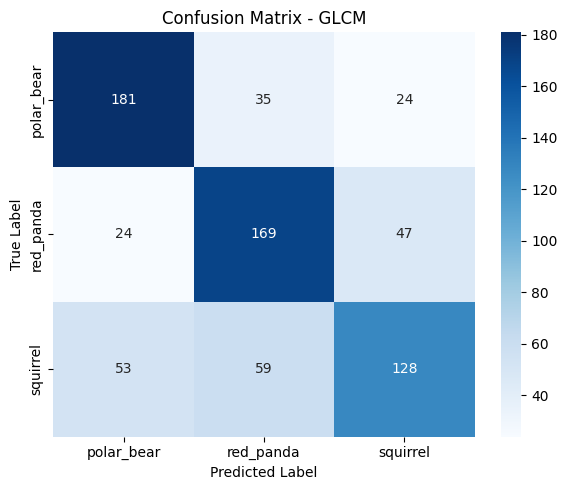

In [45]:
model_glcm = train_and_evaluate_svm(X_glcm, y_encoded, method_name="GLCM")

# **Hyperparameter Tunning Model**

In [46]:
# Hyperparameter Tunning Model SVM
def tune_svm_with_gridsearch(X_features, y_labels, method_name="Metode"):
    print(f"\nGrid Search SVM untuk metode: {method_name}")

    # Normalisasi fitur
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

    # Definisikan parameter grid
    param_grid = [
        {
            'kernel': ['linear'],
            'C': [0.1, 1, 10, 100]
        },
        {
            'kernel': ['rbf'],
            'C': [0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1]
        }
    ]

    # Inisialisasi SVC dan GridSearch
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Hasil terbaik
    best_model = grid_search.best_estimator_
    print(f"\nParameter Terbaik untuk {method_name}: {grid_search.best_params_}")

    # Evaluasi di test set
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nEvaluasi Model Terbaik ({method_name})")
    print(f"Akurasi: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    plot_confusion_matrix(y_test, y_pred, method_name)

    return best_model


Grid Search SVM untuk metode: HOG
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Parameter Terbaik untuk HOG: {'C': 0.1, 'kernel': 'linear'}

Evaluasi Model Terbaik (HOG)
Akurasi: 0.6069
              precision    recall  f1-score   support

  polar_bear       0.64      0.69      0.67       240
   red_panda       0.59      0.58      0.59       240
    squirrel       0.58      0.55      0.56       240

    accuracy                           0.61       720
   macro avg       0.61      0.61      0.61       720
weighted avg       0.61      0.61      0.61       720



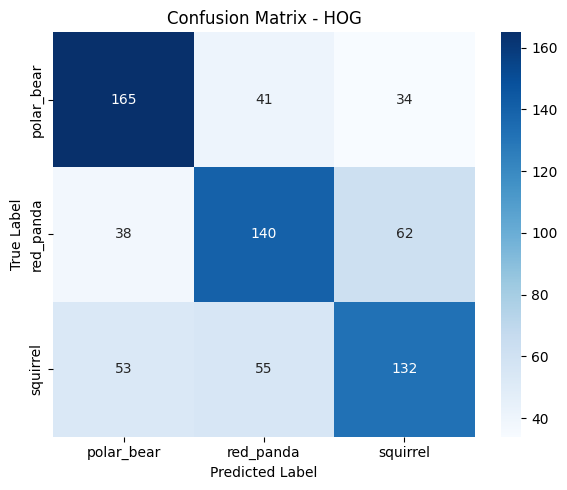

In [47]:
best_model_hog = tune_svm_with_gridsearch(X_hog, y_encoded, method_name="HOG")


Grid Search SVM untuk metode: LBP
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Parameter Terbaik untuk LBP: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Evaluasi Model Terbaik (LBP)
Akurasi: 0.9056
              precision    recall  f1-score   support

  polar_bear       0.88      0.95      0.91       240
   red_panda       0.92      0.94      0.93       240
    squirrel       0.92      0.82      0.87       240

    accuracy                           0.91       720
   macro avg       0.91      0.91      0.90       720
weighted avg       0.91      0.91      0.90       720



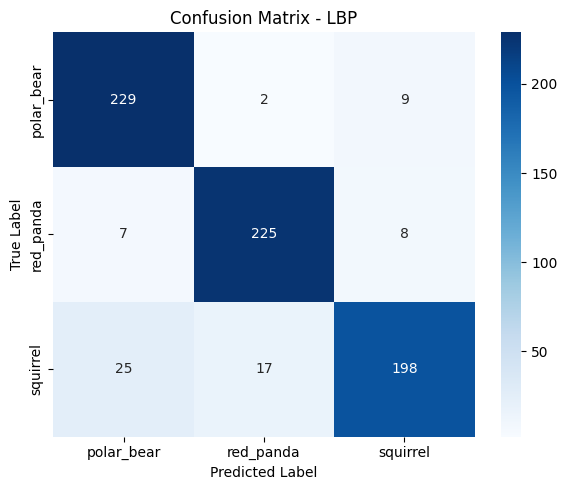

In [48]:
best_model_lbp = tune_svm_with_gridsearch(X_lbp, y_encoded, method_name="LBP")


Grid Search SVM untuk metode: Gabor Filter
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Parameter Terbaik untuk Gabor Filter: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Evaluasi Model Terbaik (Gabor Filter)
Akurasi: 0.5194
              precision    recall  f1-score   support

  polar_bear       0.59      0.61      0.60       240
   red_panda       0.47      0.43      0.45       240
    squirrel       0.49      0.52      0.50       240

    accuracy                           0.52       720
   macro avg       0.52      0.52      0.52       720
weighted avg       0.52      0.52      0.52       720



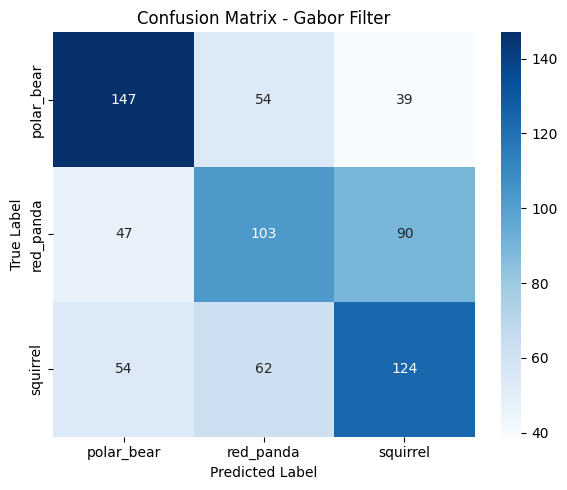

In [49]:
best_model_gabor = tune_svm_with_gridsearch(X_gabor, y_encoded, method_name="Gabor Filter")


Grid Search SVM untuk metode: GLCM
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Parameter Terbaik untuk GLCM: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Evaluasi Model Terbaik (GLCM)
Akurasi: 0.7750
              precision    recall  f1-score   support

  polar_bear       0.80      0.83      0.81       240
   red_panda       0.78      0.78      0.78       240
    squirrel       0.74      0.72      0.73       240

    accuracy                           0.78       720
   macro avg       0.77      0.78      0.77       720
weighted avg       0.77      0.78      0.77       720



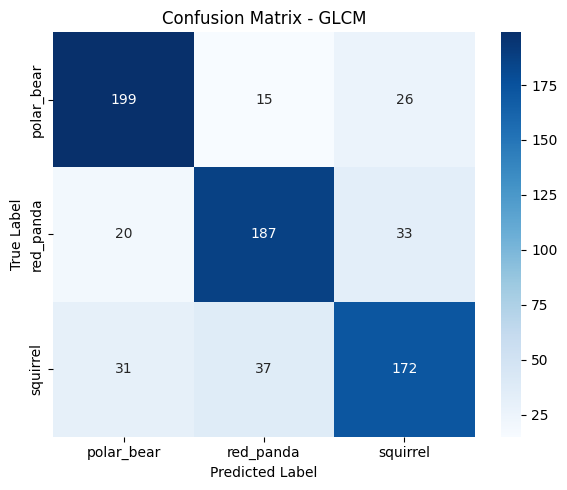

In [50]:
best_model_glcm = tune_svm_with_gridsearch(X_glcm, y_encoded, method_name="GLCM")

In [51]:
# Evaluasi Stabilitas Model
scores = cross_val_score(SVC(C=100, gamma=1, kernel='rbf'), 
                         X_lbp, y_encoded, cv=5, scoring='accuracy')

print("Akurasi per fold:", scores)
print("Akurasi rata-rata:", scores.mean())

Akurasi per fold: [0.6625     0.7        0.65277778 0.6875     0.69305556]
Akurasi rata-rata: 0.6791666666666666


# **Testing Model**

In [22]:
# LabelEncoder
le = LabelEncoder()
y_labels = le.fit_transform(augmented_labels)

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lbp)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# SVM model
model = SVC(kernel='rbf', C=1000, gamma=1)
model.fit(X_train, y_train)
best_model = model

In [29]:
# Tes dengan 3 gambar (1 dari tiap kelas secara acak)
def random_sample_test(images, labels, classes):
    sampel = []
    for cls in classes:
        idx = [i for i, lbl in enumerate(labels) if lbl == cls]
        random_idx = random.choice(idx)
        sampel.append((images[random_idx], labels[random_idx]))
    return sampel

random_samples = random_sample_test(images, labels, selected_classes)

In [30]:
# Pra-pemrosesan gambar uji
def test_image_process(image_list):
    lpb_test = []
    label_test = []
    for img, label in image_list:
        pre_img = preprocess_image(img)
        lbp_feat = extract_lbp_features(pre_img)
        lpb_test.append(lbp_feat)
        label_test.append(label)
    return np.array(lpb_test), label_test

X_sample, y_sample = test_image_process(random_samples)

In [31]:
# Proses gambar uji
X_sample, y_sample = test_image_process(random_samples)
X_sample_scaled = scaler.transform(X_sample)

# Prediksi
sample_pred = best_model.predict(X_sample_scaled)
y_sample_pred = le.inverse_transform(sample_pred)

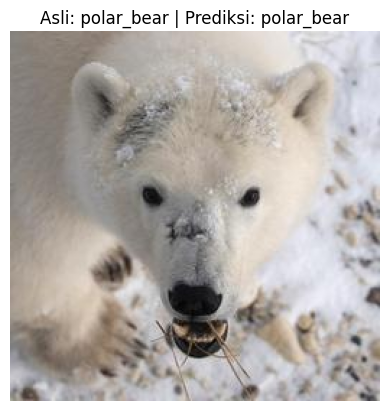

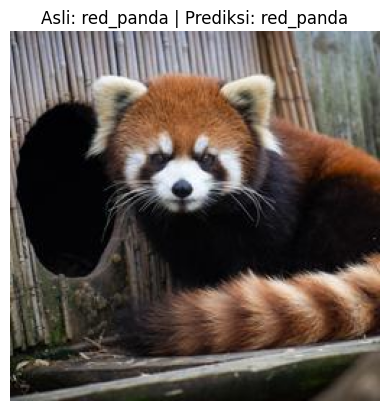

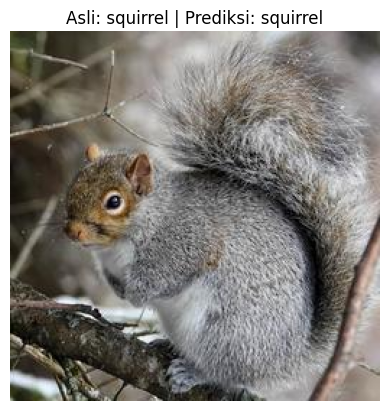

In [32]:
# Tampilkan hasil
for i in range(len(y_sample)):
    plt.imshow(random_samples[i][0])
    plt.title(f"Asli: {y_sample[i]} | Prediksi: {y_sample_pred[i]}")
    plt.axis('off')
    plt.show()

In [33]:
# Simpan model
joblib.dump(best_model, 'model_svm_lbp.pkl')
joblib.dump(scaler, 'scaler_lbp.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model, scaler, dan LabelEncoder berhasil disimpan.")

Model, scaler, dan LabelEncoder berhasil disimpan.
